<h3>Train CCS Predicting Models, Predict CCS Values of Metabolites, Compare Them</h3>

<h4>Import Data</h4>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ccs_df = pd.read_csv('/home/lbarbut/data/ccs/METLIN_IMS_all plot CV %3C2% _dimers.csv')
ccs_df

,Molecule Name,Molecular Formula,METLIN ID,Precursor Adduct,CCS1,CCS2,CCS3,CCS_AVG,% CV,m/z,...,m/z.1,Dimer,Dimer.1,dimer line,CCS,m/z.2,pubChem,inchi,smiles,InChIKEY
0,"3-[3-(2,3-dihydroindol-1-yl)propyl]-1-[(4-fluo...",C19H22FN3O,1181481.0,328.1820[M+H],176.63,176.63,176.63,176.63,0.0,328.1820,...,328.1820,209.886594,Monomer,NaN,135.0,50.0,25345055,InChI=1S/C19H22FN3O/c20-17-8-6-15(7-9-17)14-22...,O=C(NCc1ccc(cc1)F)NCCCN1CCc2c1cccc2,DWYWDNMZIWKHFM-UHFFFAOYSA-N
1,"3-{[1,1'-biphenyl]-4-ylmethylidene}-6-fluoro-2...",C22H15FO3S,1191359.0,379.0799[M+H],192.26,192.26,192.26,192.26,0.0,379.0799,...,379.0799,223.588309,Monomer,NaN,310.0,700.0,NaN,InChI=1S/C22H15FO3S/c23-19-10-11-21-20(13-19)2...,Fc1ccc2c(c1)C(=O)C(=Cc1ccc(cc1)c1ccccc1)CS2(=O)=O,MFNGEIZTLYGVQK-UHFFFAOYSA-N
2,"1-{[3-(4-methoxyphenyl)-1,2,4-oxadiazol-5-yl]m...",C25H28N4O3,1228206.0,433.2234[M+H],211.12,211.12,211.12,211.12,0.0,433.2234,...,433.2234,238.163739,Monomer,NaN,NaN,NaN,17541371,InChI=1S/C25H28N4O3/c1-31-21-10-8-19(9-11-21)2...,COc1ccc(cc1)c1noc(n1)CN1CCN(CC1)C(=O)C1(CCC1)c...,YPHGAJRHIVSPSX-UHFFFAOYSA-N
3,3-[2-oxo-2-(4-phenylmethanesulfonylpiperazin-1...,C22H30N4O5S,1176932.0,463.2010[M+H],204.22,204.22,204.22,204.22,0.0,463.2010,...,463.2010,246.233709,Monomer,NaN,NaN,NaN,16295966,InChI=1S/C22H30N4O5S/c27-19(16-26-20(28)22(23-...,O=C(N1CCN(CC1)S(=O)(=O)Cc1ccccc1)CN1C(=O)NC2(C...,ALHVXFHLDXYEII-UHFFFAOYSA-N
4,"2-{[1,1'-biphenyl]-2-ylamino}-1-(morpholin-4-y...",C18H20N2O2,1183857.0,297.1598[M+H],174.47,174.47,174.47,174.47,0.0,297.1598,...,297.1598,201.535418,Monomer,NaN,NaN,NaN,17463671,InChI=1S/C18H20N2O2/c21-18(20-10-12-22-13-11-2...,O=C(N1CCOCC1)CNc1ccccc1c1ccccc1,YWINZXNEVGTFAX-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,--,--,--,XKTJEHXBSIDWRH-UHFFFAOYSA-N
65284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3825,NaN,NaN,NaN,--,--,--,XKTJEHXBSIDWRH-UHFFFAOYSA-N
65285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,61457,NaN,NaN,NaN,--,--,--,XKTJEHXBSIDWRH-UHFFFAOYSA-N
65286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,--,--,--,XKTJEHXBSIDWRH-UHFFFAOYSA-N


Debug Mode

In [3]:
debug_mode = True
if debug_mode:
    # Keep only the first 1000 rows
    ccs_df = ccs_df.iloc[:1000]

    # Reset the index (optional)
    ccs_df = ccs_df.reset_index(drop=True)


<h4>Data Preprocessing</h4>

In [4]:
# drop NaN Precusor Adduct rows
ccs_df = ccs_df.dropna(subset=['Precursor Adduct'])

# remove the m/z number before the Precursor Adduct since the info is also in m/z column
ccs_df.loc[:, 'Precursor Adduct'] = ccs_df['Precursor Adduct'].str.replace(r'[0-9.]+', '', regex=True)

# remove [M+Na] rows
ccs_df = ccs_df[ccs_df['Precursor Adduct'] != '[M+Na]']

# change [M+H] to [M+H]+ and [M-H] to [M-H]-
ccs_df["Precursor Adduct"] = ccs_df["Precursor Adduct"].replace({
    "[M+H]": "[M+H]+",
    "[M-H]": "[M-H]-"
})

In [5]:
print(ccs_df['Precursor Adduct'].value_counts())

Precursor Adduct
[M+H]+    1000
Name: count, dtype: int64


In [6]:
from rdkit import Chem

In [7]:
def is_valid_smiles(smiles):
    try:
        return Chem.MolFromSmiles(smiles) is not None  # True if valid, False if invalid
    except Exception:
        return False


In [8]:

# Apply validation
ccs_df["smiles_is_valid"] = ccs_df["smiles"].apply(is_valid_smiles)

invalid_smiles = ccs_df.loc[~ccs_df["smiles_is_valid"], "smiles"]  # Select invalid SMILES
# print("Invalid SMILES strings:")
# print(invalid_smiles.tolist())

# Filter out invalid SMILES, afterwards drop the is_valid column
ccs_df = ccs_df[ccs_df["smiles_is_valid"]].drop(columns=["smiles_is_valid"]).reset_index(drop=True)

[13:18:45] SMILES Parse Error: syntax error while parsing: --
[13:18:45] SMILES Parse Error: Failed parsing SMILES '--' for input: '--'
[13:18:45] SMILES Parse Error: syntax error while parsing: --
[13:18:45] SMILES Parse Error: Failed parsing SMILES '--' for input: '--'
[13:18:45] SMILES Parse Error: syntax error while parsing: --
[13:18:45] SMILES Parse Error: Failed parsing SMILES '--' for input: '--'
[13:18:45] SMILES Parse Error: syntax error while parsing: --
[13:18:45] SMILES Parse Error: Failed parsing SMILES '--' for input: '--'
[13:18:45] SMILES Parse Error: syntax error while parsing: --
[13:18:45] SMILES Parse Error: Failed parsing SMILES '--' for input: '--'
[13:18:45] SMILES Parse Error: syntax error while parsing: --
[13:18:45] SMILES Parse Error: Failed parsing SMILES '--' for input: '--'
[13:18:45] SMILES Parse Error: syntax error while parsing: --
[13:18:45] SMILES Parse Error: Failed parsing SMILES '--' for input: '--'
[13:18:45] SMILES Parse Error: syntax error whil

In [9]:
# drop NaN CCS_AVG rows
ccs_df = ccs_df.dropna(subset=['CCS_AVG'])
ccs_df.shape

(917, 21)

In [10]:
ccs_df["Instrument_type"] = "timsTOF"

In [11]:
ccs_df['CE'] = -1

<h4>Use Fiora To Predict CCS Values of Metabolites</h4>

In [12]:
# Create Metabolite column by Creating Molecular Graphs of Metabolites

from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder

CE_upper_limit = 100.0
weight_upper_limit = 1000.0

ccs_df["Metabolite"] = ccs_df["smiles"].apply(Metabolite)
ccs_df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

ccs_df["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))

[13:18:48] WARNING: not removing hydrogen atom without neighbors
[13:18:48] WARNING: not removing hydrogen atom without neighbors
[13:18:48] WARNING: not removing hydrogen atom without neighbors
[13:18:48] DEPRECATION WARNING: please use MorganGenerator
[13:18:48] DEPRECATION WARNING: please use MorganGenerator
[13:18:48] WARNING: Omitted undefined stereo

[13:18:48] DEPRECATION WARNING: please use MorganGenerator
[13:18:48] DEPRECATION WARNING: please use MorganGenerator
[13:18:48] DEPRECATION WARNING: please use MorganGenerator
[13:18:48] DEPRECATION WARNING: please use MorganGenerator
[13:18:48] DEPRECATION WARNING: please use MorganGenerator
[13:18:48] DEPRECATION WARNING: please use MorganGenerator
[13:18:48] DEPRECATION WARNING: please use MorganGenerator
[13:18:48] DEPRECATION WARNING: please use MorganGenerator
[13:18:48] DEPRECATION WARNING: please use MorganGenerator
[13:18:48] DEPRECATION WARNING: please use MorganGenerator
[13:18:48] DEPRECATION WARNING: please use MorganGe

0      None
1      None
2      None
3      None
4      None
       ... 
912    None
913    None
914    None
915    None
916    None
Name: Metabolite, Length: 917, dtype: object

In [13]:
# Assign unique Metabolite identifiers
print("Unique smiles: " + str(len(ccs_df["smiles"].unique())))

metabolite_id_map = {}
for metabolite in ccs_df["Metabolite"]:
    is_new = True
    for id, other in metabolite_id_map.items():
        if metabolite == other:
            metabolite.set_id(id)
            is_new = False
            break
    if is_new:
        new_id = len(metabolite_id_map)
        metabolite.id = new_id
        metabolite_id_map[new_id] = metabolite

ccs_df["group_id"] = ccs_df["Metabolite"].apply(lambda x: x.get_id())
ccs_df["num_per_group"] = ccs_df["group_id"].map(ccs_df["group_id"].value_counts())

for i, data in ccs_df.iterrows():
    data["Metabolite"].set_loss_weight(1.0 / data["num_per_group"])
ccs_df["loss_weight"] = ccs_df["Metabolite"].apply(lambda x: x.loss_weight)

def print_df_stats(df):
    num_spectra = df.shape[0]
    num_ids = len(df["group_id"].unique())
    
    print(f"Dataframe stats: {num_spectra} spectra covering {num_ids} unique structures")

print_df_stats(ccs_df)

Unique smiles: 917
Dataframe stats: 917 spectra covering 917 unique structures


In [14]:
ccs_df.apply(lambda x: x["Metabolite"].set_id(x["group_id"]), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
912    None
913    None
914    None
915    None
916    None
Length: 917, dtype: object

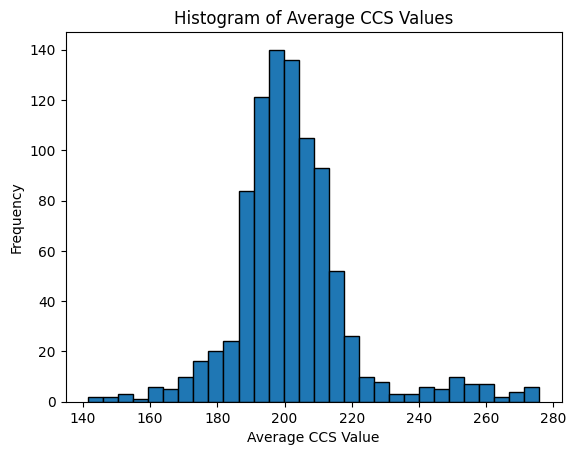

In [15]:
# Plot histogram of CCS_AVG column

plt.hist(ccs_df['CCS_AVG'], bins=30, edgecolor='black')
plt.xlabel('Average CCS Value')
plt.ylabel('Frequency')
plt.title('Histogram of Average CCS Values')
plt.show()

<h5>Predict CCS Values</h5>

In [16]:
import json
from fiora.GNN.GNNModules import GNNCompiler
from fiora.MS.SimulationFramework import SimulationFramework

In [17]:
# Load best model

dev="cuda:1"
#MODEL_PATH = f"{home}/data/metabolites/pretrained_models/pre_package/v0.0.1_merged_depth6_Jan24.pt"
MODEL_PATH = "/home/lbarbut/models/ccs_models/v0.0.1_merged_depth6_Aug24_sqrt+CCS+RT_drop3.pt" # New sqrt model (improved)

try:
    model = GNNCompiler.load_from_state_dict(MODEL_PATH)
    print("Model loaded from state dict without errors.")
except:
    raise NameError("Error: Failed loading from state dict.")
        

model.eval()
model = model.to(dev)

model.model_params

spectral_modules = ["node_embedding", "edge_embedding", "GNN_module", "edge_module", "precursor_module", "RT_module"]
for module in spectral_modules:
    model.freeze_submodule(module)

for name, param in model.named_parameters():
    if param.requires_grad:print(f"{name}: requires gradients")

Model loaded from state dict without errors.
CCS_module.dense_layers.0.weight: requires gradients
CCS_module.dense_layers.0.bias: requires gradients
CCS_module.dense_layers.1.weight: requires gradients
CCS_module.dense_layers.1.bias: requires gradients
CCS_module.output_layer.weight: requires gradients
CCS_module.output_layer.bias: requires gradients


In [18]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: requires gradients")
    # else:
    #     print(f"{name}: does not require gradients (frozen)")

CCS_module.dense_layers.0.weight: requires gradients
CCS_module.dense_layers.0.bias: requires gradients
CCS_module.dense_layers.1.weight: requires gradients
CCS_module.dense_layers.1.bias: requires gradients
CCS_module.output_layer.weight: requires gradients
CCS_module.output_layer.bias: requires gradients


<h5>Include Metadata</h5>

In [19]:
metadata_key = { "collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "m/z", 
                 'precursor_mode': "Precursor Adduct",
                 "ccs": "CCS_AVG"
                 }

ccs_df["summary"] = ccs_df.apply(lambda x: {key: x[name] for key, name in metadata_key.items()}, axis=1)
ccs_df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
ccs_df.apply(lambda x: x["Metabolite"].set_loss_weight(x["loss_weight"]), axis=1)

ccs_df["geo_data"] = ccs_df["Metabolite"].apply(lambda x: x.as_geometric_data(with_labels=False, ccs_only=True).to(dev)).values

In [20]:
ccs_df["summary"][0]

{'collision_energy': -1,
 'instrument': 'timsTOF',
 'precursor_mz': 328.182,
 'precursor_mode': '[M+H]+',
 'ccs': 176.63,
 'molecular_weight': 327.174690544}

In [21]:
ccs_df["geo_data"][0].weight

327.174690544

<h5>Prediction</h5>

In [22]:
fiora = SimulationFramework(None, dev=dev, with_RT=True, with_CCS=True)
fiora.pred_all(ccs_df, model)


In [23]:
ccs_df['CCS_pred'] = ccs_df["Metabolite"].apply(lambda x: x.CCS_pred)

In [24]:
ccs_df['CCS_pred']

0      tensor(191.9466, device='cuda:1')
1      tensor(191.9459, device='cuda:1')
2      tensor(208.1397, device='cuda:1')
3      tensor(213.6994, device='cuda:1')
4      tensor(171.2999, device='cuda:1')
                     ...                
912    tensor(187.3998, device='cuda:1')
913    tensor(201.0114, device='cuda:1')
914    tensor(195.6432, device='cuda:1')
915    tensor(190.1264, device='cuda:1')
916    tensor(205.2630, device='cuda:1')
Name: CCS_pred, Length: 917, dtype: object

Measure MSE of predicted and experimental values

In [25]:
mse = 0

mse = ((ccs_df['CCS_AVG'] - ccs_df['CCS_pred'].apply(lambda x: x.item()))**2).mean()
print(mse)


375.1230545588101


Plot Experimental CCS vs. Predicted CCS

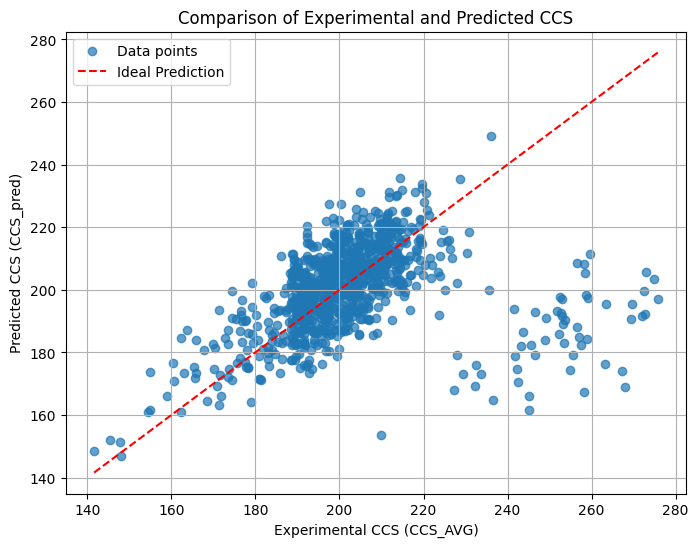

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(ccs_df['CCS_AVG'], ccs_df['CCS_pred'].apply(lambda x: x.item()), alpha=0.7, label="Data points") #alpha:transparency
plt.plot([ccs_df['CCS_AVG'].min(), ccs_df['CCS_AVG'].max()],
         [ccs_df['CCS_AVG'].min(), ccs_df['CCS_AVG'].max()],
         color='red', linestyle='--', label="Ideal Prediction")

plt.xlabel("Experimental CCS (CCS_AVG)")
plt.ylabel("Predicted CCS (CCS_pred)")
plt.title("Comparison of Experimental and Predicted CCS")
plt.legend()
plt.grid()
plt.show()

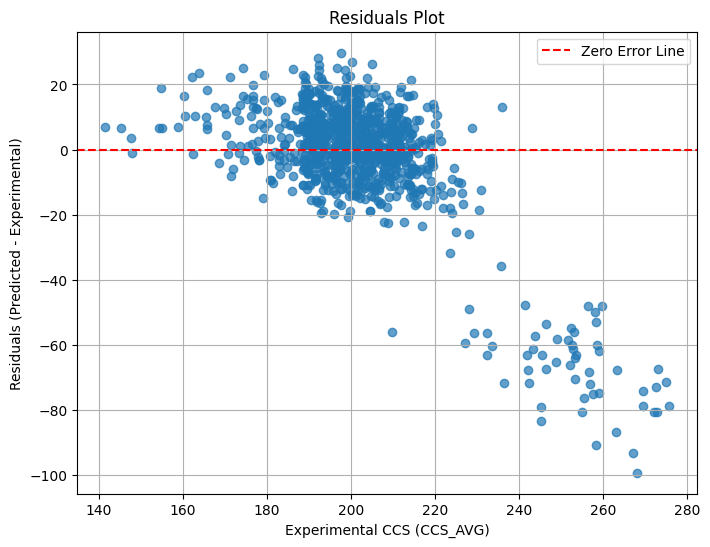

In [27]:
plt.figure(figsize=(8, 6))
residuals = ccs_df['CCS_pred'].apply(lambda x: x.item()) - ccs_df['CCS_AVG']
plt.scatter(ccs_df['CCS_AVG'], residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label="Zero Error Line")

plt.xlabel("Experimental CCS (CCS_AVG)")
plt.ylabel("Residuals (Predicted - Experimental)")
plt.title("Residuals Plot")
plt.legend()
plt.grid()
plt.show()

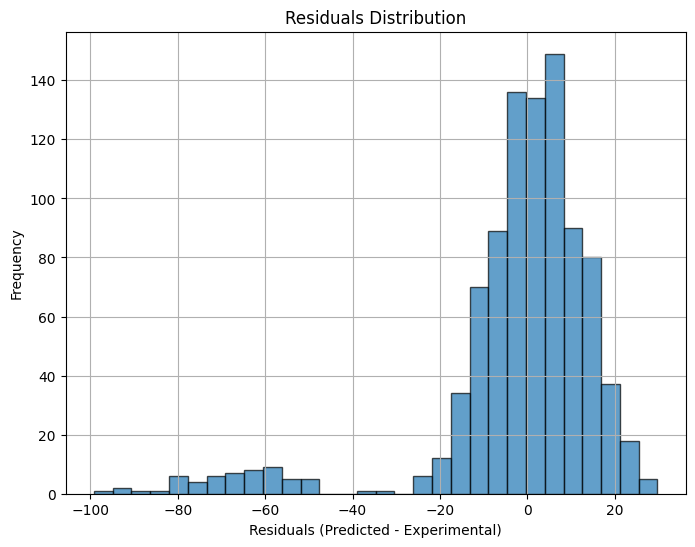

In [28]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')

plt.xlabel("Residuals (Predicted - Experimental)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.grid()
plt.show()

In [29]:
from sklearn.metrics import r2_score

# Berechnung des R²-Werts
r2 = r2_score(ccs_df['CCS_AVG'], ccs_df['CCS_pred'].apply(lambda x: x.item()))
print(f"R²-Wert: {r2}")

R²-Wert: -0.18680409730417824


In [30]:
ccs_df['error'] = (ccs_df['CCS_AVG'] - ccs_df['CCS_pred'].apply(lambda x: x.item())).abs()

# 100 biggest deviation
largest_errors_df = ccs_df.nlargest(100, 'error')
print("Größte Abweichungen:")
print(largest_errors_df[['CCS_AVG', 'CCS_pred', 'error']])

Größte Abweichungen:
     CCS_AVG                           CCS_pred      error
239   268.07  tensor(168.8419, device='cuda:1')  99.228066
240   267.18  tensor(173.8828, device='cuda:1')  93.297172
246   258.27  tensor(167.4680, device='cuda:1')  90.802043
10    263.15  tensor(176.4288, device='cuda:1')  86.721213
259   245.18  tensor(161.6549, device='cuda:1')  83.525139
..       ...                                ...        ...
780   192.84  tensor(173.4232, device='cuda:1')  19.416843
52    203.99  tensor(223.3459, device='cuda:1')  19.355947
12    211.86  tensor(231.1652, device='cuda:1')  19.305176
483   205.67  tensor(224.8802, device='cuda:1')  19.210203
565   201.67  tensor(220.6387, device='cuda:1')  18.968672

[100 rows x 3 columns]


In [31]:
# not a very interpretable plot

import seaborn as sns

# ccs_pred_values = largest_errors_df['CCS_pred'].apply(lambda x: x.item())

# plt.figure(figsize=(10, 6))

# # Scatter plot of the CCS_AVG vs. CCS_pred
# sns.scatterplot(data=largest_errors_df, x='CCS_AVG', y=ccs_pred_values)
# plt.plot([largest_errors_df['CCS_AVG'].min(), largest_errors_df['CCS_AVG'].max()],
#          [largest_errors_df['CCS_AVG'].min(), largest_errors_df['CCS_AVG'].max()],
#          color='red', linestyle='--', label="Ideal Prediction (y = x)")
# # Titles and labels
# plt.title("100 Biggest Errors Between CCS_AVG and CCS_pred")
# plt.xlabel("CCS_AVG")
# plt.ylabel("CCS_pred")
# plt.legend()
# plt.grid()

plt.show()

In [32]:
# R² for M+H and M-H seperately
if not debug_mode:
    for mode in ['[M+H]+', '[M-H]-']:
        mode_df = ccs_df[ccs_df['Precursor Adduct'] == mode]
        r2_mode = r2_score(mode_df['CCS_AVG'], mode_df['CCS_pred'].apply(lambda x: x.item()))
        print(f"R² for {mode}: {r2_mode}")

Split Train/Test/Validation Data

In [33]:
from sklearn.model_selection import train_test_split

seed = 42

def train_val_test_split(keys, test_size=0.1, val_size=0.1, rseed=seed):
    temp_keys, test_keys = train_test_split(keys, test_size=test_size, random_state=rseed)
    adjusted_val_size = val_size / (1 - test_size)
    train_keys, val_keys = train_test_split(temp_keys, test_size=adjusted_val_size, random_state=rseed)
    
    return train_keys, val_keys, test_keys

group_ids = ccs_df["group_id"].astype(int)
keys = np.unique(group_ids)
example_not_in_test_split = True

train, val, test = train_val_test_split(keys, rseed=seed)
ccs_df["datasplit"] = ccs_df["group_id"].apply(lambda x: 'train' if x in train else 'validation' if x in val else 'test' if x in test else 'VALUE ERROR')


In [34]:
test_df = ccs_df[ccs_df['datasplit'] == 'test']

In [35]:
train_df = ccs_df[ccs_df['datasplit'] == 'train']

In [36]:
if not debug_mode:
    for mode in ['[M+H]+', '[M-H]-']:
        mode_df = test_df[test_df['Precursor Adduct'] == mode]
        r2_mode = r2_score(mode_df['CCS_AVG'], mode_df['CCS_pred'].apply(lambda x: x.item()))
        print(f"R² for {mode} (Test Set): {r2_mode}")

/tmp/ipykernel_3482481/2330683015.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['carbon_ratios'] = test_df["Metabolite"].apply(lambda x: x.element_distribution['C'])
/tmp/ipykernel_3482481/2330683015.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["carbon_bin"] = pd.cut(test_df["carbon_ratios"], bins=10)


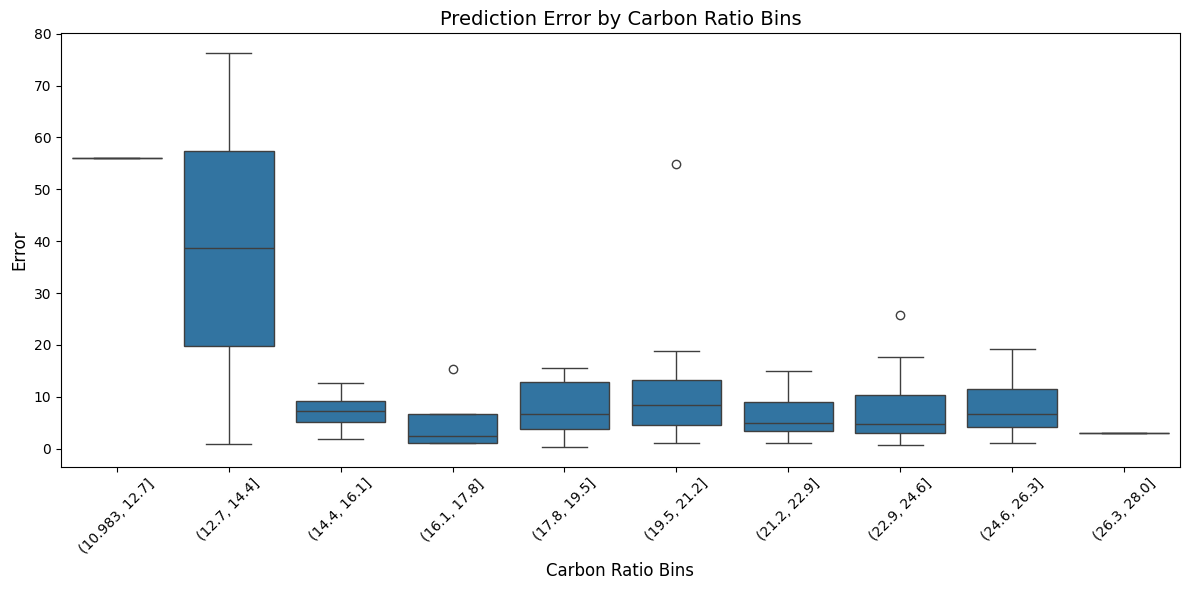

In [37]:
# Plot Error Compared to Carbon-Ratio

test_df['carbon_ratios'] = test_df["Metabolite"].apply(lambda x: x.element_distribution['C'])

test_df["carbon_bin"] = pd.cut(test_df["carbon_ratios"], bins=10)

plt.figure(figsize=(12, 6))
sns.boxplot(data=test_df, x="carbon_bin", y="error")
plt.title("Prediction Error by Carbon Ratio Bins", fontsize=14)
plt.xlabel("Carbon Ratio Bins", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

In [38]:
def is_element_included(element, metabolite):    # element as symbol
    if element in metabolite.node_elements:
        return True
    else:
        return False

/tmp/ipykernel_3482481/2538906055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['I_included'] = test_df["Metabolite"].apply(lambda x : is_element_included('I', x))


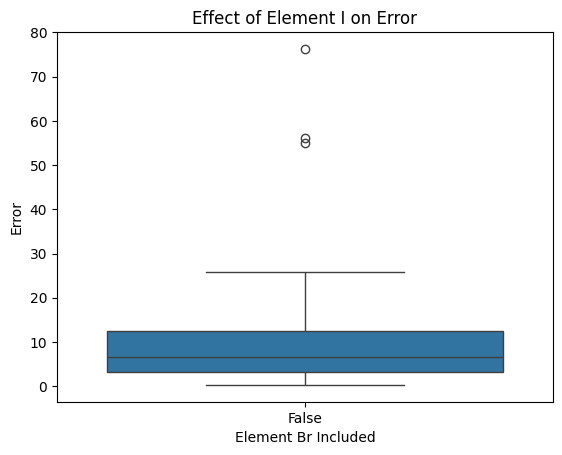

In [39]:
# Plot Error Depending on Iod Existence

test_df['I_included'] = test_df["Metabolite"].apply(lambda x : is_element_included('I', x))

sns.boxplot(data=test_df, x='I_included', y='error')
plt.xlabel("Element Br Included")
plt.ylabel("Error")
plt.title("Effect of Element I on Error")
plt.show()

Classify Metabolites Based on Murcko Scaffold and Evaluate the Error Rates Depending on These Classes

In [40]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

def get_murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    return None

/tmp/ipykernel_3482481/3133248743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['scaffold'] = test_df['smiles'].apply(lambda x: get_murcko_scaffold(x))
/tmp/ipykernel_3482481/3133248743.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['scaffold'] = test_df['scaffold'].apply(
/tmp/ipykernel_3482481/3133248743.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

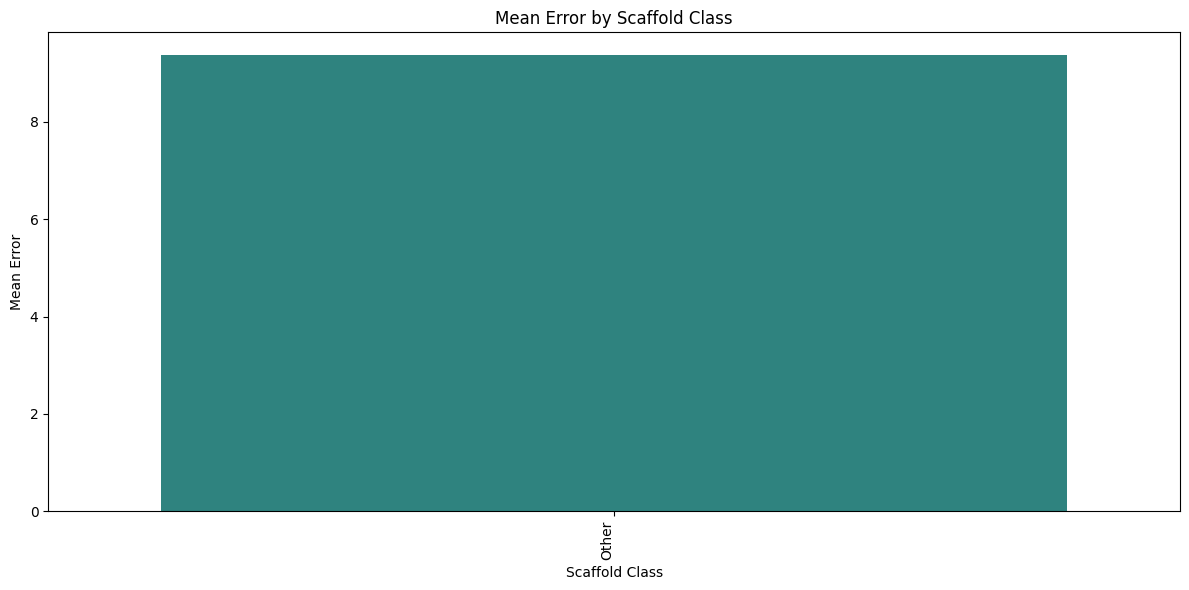

In [41]:
# create scaffold column, group by scaffold, calculate mean error for each scaffold class

test_df['scaffold'] = test_df['smiles'].apply(lambda x: get_murcko_scaffold(x))
scaffold_counts = test_df['scaffold'].value_counts()

# Define a threshold for grouping rare scaffolds
threshold = 5

# Replace rare scaffolds with 'Other'
test_df['scaffold'] = test_df['scaffold'].apply(
    lambda x: x if scaffold_counts[x] > threshold else 'Other'
)

grouped_data = test_df.groupby('scaffold')['error'].mean().reset_index()

grouped_data = grouped_data.sort_values(by='error')

# plot error for each scaffold class
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_data, x='scaffold', y='error', palette="viridis")

plt.title("Mean Error by Scaffold Class")
plt.xlabel("Scaffold Class")
plt.ylabel("Mean Error")
plt.xticks(rotation=90, ha='right')  # rotate x-axis labels if there are many scaffolds
plt.tight_layout()
plt.show()

In [42]:
from rdkit.Chem import Draw

if not debug_mode:
    # Get the top 5 scaffolds with the highest and lowest errors
    top_5_scaffolds = grouped_data.nlargest(5, 'error')['scaffold']
    bottom_5_scaffolds = grouped_data.nsmallest(5, 'error')['scaffold']

    scaffolds_to_plot = pd.concat([top_5_scaffolds, bottom_5_scaffolds])

    # Create a new DataFrame with the corresponding SMILES for top and bottom scaffolds
    top_bottom_scaffolds = test_df[test_df['scaffold'].isin(scaffolds_to_plot)]

    molecule_images = []

    # Create a molecule image for each scaffold in the top 5 and bottom 5
    for scaffold in scaffolds_to_plot:
        scaffold_smiles = top_bottom_scaffolds[top_bottom_scaffolds['scaffold'] == scaffold]['smiles'].iloc[0]
        mol = Chem.MolFromSmiles(scaffold_smiles)
        img = Draw.MolToImage(mol)
        molecule_images.append(img)

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for i, ax in enumerate(axes.flatten()):
        if i < 5:
            ax.set_title("Top Error")  # Set title for top 5
        else:
            ax.set_title("Bottom Error")  # Set title for bottom 5
        ax.imshow(molecule_images[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [43]:
import fiora.MOL.constants

def rare_element_included(metabolite):
    rare_elements = fiora.MOL.constants.RARE_ELEMENTS
    included = False
    for element in rare_elements:
        included = included or is_element_included(element, metabolite)
    return included

/tmp/ipykernel_3482481/2821679205.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['rare_element_included'] = test_df["Metabolite"].apply(lambda x : rare_element_included(x))


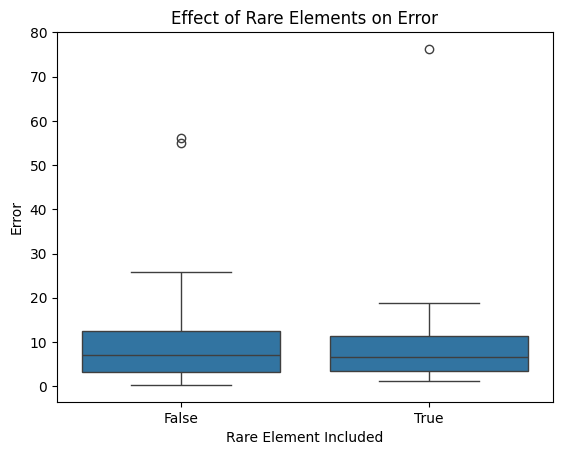

In [44]:
# Plot Error Depending on Rare Element Existence

test_df['rare_element_included'] = test_df["Metabolite"].apply(lambda x : rare_element_included(x))

sns.boxplot(data=test_df, x='rare_element_included', y='error')
plt.xlabel("Rare Element Included")
plt.ylabel("Error")
plt.title("Effect of Rare Elements on Error")
plt.show()

In [45]:
# import torch
# from fiora.GNN.Trainer import Trainer

In [46]:
# loss_fn = torch.nn.MSELoss() 

# rt_epochs = 500 # 300
# rt_batch = 64 #128
# rt_lr = 0.005

# def train_rt_model(rt_lr=rt_lr, rt_batch=rt_batch, rt_epochs=rt_epochs):        
#     y_label = 'compiled_probsALL'
#     optimizer = torch.optim.Adam(model.parameters(), lr=rt_lr)
#     train_keys, val_keys = ccs_df[ccs_df["dataset"] == "training"]["group_id"].unique(), ccs_df[ccs_df["dataset"] == "validation"]["group_id"].unique()
#     trainer = Trainer(geo_data, y_tag=y_label, problem_type="regression", train_keys=train_keys, val_keys=val_keys, metric_dict=None, split_by_group=True, seed=seed, device=dev)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 8, factor=0.8, mode = 'min', verbose = True)
#     checkpoints = trainer.train(model, optimizer, loss_fn, scheduler=scheduler, batch_size=rt_batch, epochs=rt_epochs, val_every_n_epochs=1, with_CCS=True, with_RT=True, rt_metric=True, masked_validation=False, tag=tag) #, mask_name="compiled_validation_maskALL")   

#     return model, checkpoints

In [47]:
# model.set_dropout_rate(input_dropout=0.5, latent_dropout=0.5)

# model, cp = train_rt_model()

In [48]:
datasplit_value_counts = ccs_df['datasplit'].value_counts()
print(datasplit_value_counts)

datasplit
train         733
validation     92
test           92
Name: count, dtype: int64


In [49]:
ccs_df['carbon_ratio'] = ccs_df['Metabolite'].apply(lambda x: x.element_distribution['C'] / len(x.node_elements))

<h4>Class PropertyTrainer</h4>

In [50]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch_geometric.loader as geom_loader
from torchmetrics import Accuracy, MetricTracker, MetricCollection, Precision, Recall, PrecisionRecallCurve, MeanSquaredError, MeanAbsoluteError, R2Score
from sklearn.model_selection import train_test_split
from typing import Literal, List, Callable, Any, Dict

from fiora.GNN.Trainer import Trainer
from fiora.GNN.Datasets import collate_graph_batch, collate_graph_edge_batch
from fiora.GNN.Losses import WeightedMSELoss, WeightedMAELoss

In [51]:
class PropertyTrainer(Trainer):
    def __init__(self, data: Any, train_val_split: float= 0.8, split_by_group: bool=False, only_training: bool=False, train_keys: List[int]=[], val_keys: List[int]=[], test_keys: List[int]=[], y_tag: str="y", metric_dict: Dict=None, problem_type: Literal["classification", "regression", "softmax_regression"]="classification", library: Literal["standard", "geometric"]="geometric", num_workers: int=0, seed: int=42, device: str="cpu"):
        
        super().__init__(data, train_val_split, split_by_group, only_training, train_keys, val_keys, test_keys, seed, num_workers, device)
        self.y_tag = y_tag
        self.problem_type = problem_type

        self.data = data 
         
        # Initialize torch metrics based on dictionary 
        if metric_dict:
            self.metrics = {
                data_split: MetricTracker(MetricCollection({
                        t: M() for t,M in metric_dict.items()
                    })).to(device)
                for data_split in ["train", "val", "test"]
            }
        else:
            self.metrics = self._get_default_metrics(problem_type)
        self.loader_base = geom_loader.DataLoader if library == "geometric" else DataLoader
    
    def _training_loop(self, model, dataloader, optimizer, loss_fn, metrics, property: str="ccs", with_weights=False, with_RT=False, with_CCS=True, rt_metric=False, title=""):
        metrics.increment()   

        for batch in dataloader: # enumerate  
            # Feed forward
            model.train() # training mode
            
            y_pred = model(batch)
            
            # print("Predicted shape:", y_pred[property].shape)
            # print("Target shape:", batch["ccs"].shape)

            target = batch.ccs.to(torch.float32)
            target = target.view(-1, 1)

            loss = loss_fn(y_pred[property], target)  

            # Backpropagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        

    def _validation_loop(self, model, dataloader, loss_fn, metrics, with_weights=False, with_RT=False,  with_CCS=True, property: str="ccs", rt_metric=False, title="Validation"):
        metrics.increment()
        with torch.no_grad():
            for batch in dataloader:
                model.eval()
                y_pred = model(batch) # with_CCS = True
                loss = loss_fn(y_pred[property], batch[property])
                    
                metrics(y_pred[property], batch[property]) # call update                      

        # End of Validation cycle
        stats = metrics.compute()
        print(f'\t{title} RMSE: {torch.sqrt(stats["mse"]):>.4f}')
        return stats
    
    def _test_loop(self, model, dataloader, loss_fn, metrics, property: str="ccs", rt_metric=False):
        metrics.increment()
        with torch.no_grad():
            for batch in dataloader:
                model.eval()
                y_pred = model(batch)  # Forward pass
                loss = loss_fn(y_pred[property], batch[property])

                metrics(y_pred[property], batch[property])  # Call update on metrics

        # End of Test cycle
        stats = metrics.compute()
        print(f'\tTest RMSE: {torch.sqrt(stats["mse"]):>.4f}')
        return stats
        
    # Training function
    def train(self, model, optimizer, loss_fn, scheduler=None, batch_size=16, epochs=2, val_every_n_epochs=1, with_RT=True, with_CCS=True, rt_metric=False, tag="") -> Dict[str, Any]:
        
        # Set up checkpoint system and model info
        self._init_checkpoint_system(save_path=f"../../checkpoint_{tag}.best.pt")
        model.model_params["training_label"] = self.y_tag
        
        # Stage data into dataloader
        training_loader = self.loader_base(self.data, batch_size=batch_size, num_workers=self.num_workers, shuffle=True)
        if not self.only_training:
            validation_loader = self.loader_base(self.validation_data, batch_size=batch_size, num_workers=self.num_workers, shuffle=True)
        using_weighted_loss_func = isinstance(loss_fn, WeightedMSELoss) | isinstance(loss_fn, WeightedMAELoss)
        
        # Main loop
        for e in range(epochs):
            # Training
            self._training_loop(model, training_loader, optimizer, loss_fn, self.metrics["train"], title=f'Epoch {e + 1}/{epochs}: ', with_weights=using_weighted_loss_func, with_RT=with_RT, with_CCS=with_CCS, rt_metric=rt_metric)
            # Validation
            is_val_cycle = not self.only_training and ((e + 1) % val_every_n_epochs == 0)
            if is_val_cycle:   
                val_stats = self._validation_loop(model, validation_loader, loss_fn, self.metrics["val"], with_weights=using_weighted_loss_func, with_RT=with_RT, with_CCS=with_CCS, rt_metric=rt_metric,  title="Validation")
                
                # Update checkpoint
                if val_stats["mse"].tolist() < self.checkpoint_stats["val_loss"]:
                    self._update_checkpoint({"epoch": e+1, "val_loss": val_stats["mse"].tolist()}, model)
                    print(f"\t >> Set new checkpoint to epoch {e+1}")
            
            # End of epoch: Advance scheduler
            if scheduler:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    if is_val_cycle:
                        scheduler.step(torch.sqrt(val_stats["mse"]))
                else:
                    scheduler.step()
                    
        print("Finished Training!")
        return self.checkpoint_stats

    def test(self, model, loss_fn, batch_size=16, tag="") -> Dict[str, Any]:
        """
        Test the trained model on the test dataset and compute the RMSE.
        """
        if model is None:
            raise ValueError("Model is None. Ensure the model is correctly initialized and passed.")

        # Stage test data into dataloader
        test_loader = self.loader_base(self.test_data, batch_size=batch_size, num_workers=self.num_workers, shuffle=False)

        # Test loop
        print(f"Testing model: {tag}")
        test_stats = self._test_loop(model, test_loader, loss_fn, self.metrics["test"])

        return test_stats
    

In [52]:
# from torch_geometric.data import Dataset

# class CCSGeometricDataset(Dataset):
#     def __init__(self, data, targets, group_ids, datasplit):
#         super().__init__()
#         self.data = data  # List of graph data objects
#         self.targets = targets  # Corresponding target values (ccs_avg)
#         self.group_ids = group_ids
#         self.datasplit = datasplit

#     def len(self):
#         return len(self.data)

#     def get(self, idx):
#         graph = self.data[idx]  # PyTorch Geometric graph object
#         target = self.targets[idx]  # Associated target value
#         group_ids = self.group_ids[idx]
#         datasplit = self.datasplit[idx]
#         graph['ccs'] = target  # Add target as an attribute in the graph
#         graph['group_ids'] = group_ids
#         graph['datasplit'] = datasplit
#         return graph

In [53]:
# Extract data and targets
# ccs_targets = ccs_df['CCS_AVG'].values
# group_ids = ccs_df['group_id'].values
# datasplit_values = ccs_df['datasplit'].values

# # Create dataset
# ccs_dataset = CCSGeometricDataset(data=geo_data, targets=ccs_targets, group_ids=group_ids, datasplit=datasplit_values)

# # Create a boolean mask to index the dataset
# train_mask = ccs_df['datasplit'] == "train"
# val_mask = ccs_df['datasplit'] == "validation"

# # Index using boolean arrays
# train_data = ccs_dataset[train_mask.to_numpy()]
# val_data = ccs_dataset[val_mask.to_numpy()]

# Create DataLoaders
# train_loader = geom_loader.DataLoader(train_data, batch_size=16, shuffle=True)
# val_loader = geom_loader.DataLoader(val_data, batch_size=16, shuffle=False)

In [54]:
geo_data = ccs_df['geo_data'].values

In [55]:
# geo_data = torch.tensor(geo_data, dtype=torch.float32).to("cuda:1")

In [56]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_keys, val_keys, test_keys = ccs_df[ccs_df["datasplit"] == "train"]["group_id"].unique(), ccs_df[ccs_df["datasplit"] == "validation"]["group_id"].unique(), ccs_df[ccs_df["datasplit"] == "test"]["group_id"].unique()

trainer_fiora = PropertyTrainer(
    data=geo_data,
    y_tag='ccs',
    problem_type="regression",
    train_keys=train_keys,
    val_keys=val_keys,
    test_keys=test_keys,
    metric_dict=None,
    split_by_group=True,
    device="cuda:1"
)

# Train the model
checkpoint = trainer_fiora.train(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    val_every_n_epochs=1,
    with_CCS=True,
    tag="fiora"
)

/home/lbarbut/anaconda3/envs/fiora/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028


Using pre-set train/validation/test keys
	Validation RMSE: 17.9550
	 >> Set new checkpoint to epoch 1
	Validation RMSE: 16.3256
	 >> Set new checkpoint to epoch 2
	Validation RMSE: 16.3496
	Validation RMSE: 15.3056
	 >> Set new checkpoint to epoch 4
	Validation RMSE: 16.2066
	Validation RMSE: 15.4741
	Validation RMSE: 14.4539
	 >> Set new checkpoint to epoch 7
	Validation RMSE: 14.0704
	 >> Set new checkpoint to epoch 8
	Validation RMSE: 13.9796
	 >> Set new checkpoint to epoch 9
	Validation RMSE: 14.3743
Finished Training!


In [57]:
# DO THIS TO LOAD MODEL AND TEST THAT MODEL
# ALSO FOR DIFFERENT MODELS

model = model.load(checkpoint["file"])

In [58]:
print(geo_data[0].x)  # Assuming geo_data contains PyTorch Geometric Data objects


tensor([[6, 0, 0],
        [1, 0, 0],
        [5, 1, 0],
        [1, 2, 0],
        [1, 0, 3],
        [1, 1, 3],
        [1, 1, 3],
        [1, 0, 3],
        [1, 1, 3],
        [1, 1, 3],
        [3, 0, 0],
        [5, 1, 0],
        [1, 2, 0],
        [1, 2, 0],
        [1, 2, 0],
        [5, 0, 2],
        [1, 2, 2],
        [1, 2, 2],
        [1, 0, 3],
        [1, 0, 3],
        [1, 1, 3],
        [1, 1, 3],
        [1, 1, 3],
        [1, 1, 3]], device='cuda:1', dtype=torch.int32)


<h4>Linear Model</h4>

In [59]:
import torch.nn as nn

In [76]:
# Simple linear model
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()

        # Include model parameters as required by PropertyTrainer
        self.model_params = {
            "training_label": None, # changed to 'ccs' through y_tag in PropertyTrainer
            "input_dim": input_dim,
            "output_dim": output_dim,
        }

    def forward(self, batch):
        # Handle dictionary-style batches
        # print(batch)
        if isinstance(batch, dict):
            x = batch.get("data")
            # print(f"X: {x}")
        # Handle PyTorch Geometric-style batches
        elif hasattr(batch, "weight"): # weight
            x = batch.weight.unsqueeze(-1)
            # x = batch.weight
            # x = x.unsqueeze(0).transpose(0,1)
            # x = batch.static_graph_features
            # print(f"X: {x}")

        else:
            raise KeyError("Batch does not contain the required 'data' or 'weight' attributes.")

        # print("Input shape before passing through the model:", x.shape)

        # Ensure the input is a float tensor
        x = x.to(torch.float32).to("cuda:1")

        print(x)

        # Forward pass through the linear layer -> ReLU Activation
        output = self.activation(self.linear(x))
        print(output)

        # print("Training batch example:", batch["weight"])
        # print("Training target example:", batch["ccs"])


        # Return predictions as a dictionary with key 'ccs' (default property in PropertyTrainer)
        return {"ccs": output}

    def save(self, filepath):
        """Save the model to the given filepath."""
        # GNNCompiler.save(filepath)
        print(f"State Dict: {self.state_dict()}")
        torch.save(self.state_dict(), filepath)
        print(f"Model saved to {filepath}")

    def load(self, filepath):
        """Load the model's state from a given filepath."""
        # Load the state dictionary from the saved checkpoint
        # GNNCompiler.load(PATH=filepath)
        self.load_state_dict(torch.load(filepath, weights_only=False, map_location="cpu")) # cuda:1 / cpu
        print(f"Model loaded from {filepath}")
        
# Instantiate the model
input_dim = 1 #9
output_dim = 1
linear_model = LinearModel(input_dim, output_dim).to("cuda:1")

trainer_linear = PropertyTrainer(
    data=geo_data,
    y_tag="ccs",
    problem_type="regression",
    train_keys=train_keys,
    val_keys=val_keys,
    test_keys=test_keys,
    metric_dict=None,
    split_by_group=True,
    device="cuda:1",
    library="geometric"
)

# Train the model
linear_checkpoint = trainer_linear.train(
    model=linear_model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50,
    val_every_n_epochs=1,
    with_CCS=True,
    tag="linear"
)

Using pre-set train/validation/test keys
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:1', grad_fn=<ReluBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:1', grad_fn=<ReluBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:1', grad_fn=<ReluBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
    

/home/lbarbut/anaconda3/envs/fiora/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028


tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:1', grad_fn=<ReluBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:1', grad_fn=<ReluBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:1', grad_fn=<ReluBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
   

In [61]:
import os

filepath = linear_checkpoint["file"]
print(f"Checkpoint path: {filepath}")
print(f"File exists: {os.path.exists(filepath)}")
print(f"File size: {os.path.getsize(filepath) if os.path.exists(filepath) else 'N/A'} bytes")


Checkpoint path: ../../checkpoint_linear.best.pt
File exists: True
File size: 1714 bytes


In [62]:
# linear_model.save('../../checkpoint_test.pt')
# lin_model_test = linear_model.load('../../checkpoint_test.pt')

# print(lin_model_test)

In [63]:
linear_model = linear_model.load(linear_checkpoint["file"])

# In Debug Mode
# RuntimeError: Invalid magic number; corrupt file?
# .pt file size: 19809568 bytes

# Not In Debug Mode
# No error, linear_model = None
# .pt file size: 1600 bytes

Model loaded from ../../checkpoint_linear.best.pt


In [64]:
print(linear_model)


None


<h4>MLP Model</h4>

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MLPModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),  # First hidden layer with 32 neurons
            nn.ReLU(),
            nn.Linear(32, 16),         # Second hidden layer with 16 neurons
            nn.ReLU(),
            nn.Linear(16, output_dim)  # Output layer
        )

        # Include model parameters as required by PropertyTrainer
        self.model_params = {
            "training_label": None, # changed to 'ccs' through y_tag in PropertyTrainer
            "input_dim": input_dim,
            "output_dim": output_dim,
        }

    def forward(self, batch):
        if isinstance(batch, dict):
            x = batch.get("data")
        elif hasattr(batch, "weight"):
            x = batch.weight.unsqueeze(-1)
        else:
            raise KeyError("Batch does not contain 'data' or 'weight' attributes.")

        x = x.to(torch.float32).to("cuda:1")
        return {"ccs": self.layers(x)}

    def save(self, filepath):
        torch.save(self.state_dict(), filepath)
        print(f"Model saved to {filepath}")

    def load(self, filepath):
        self.load_state_dict(torch.load(filepath, map_location="cpu"))
        print(f"Model loaded from {filepath}")

# Instantiate Model
input_dim = 1  
output_dim = 1  
mlp_model = MLPModel(input_dim, output_dim).to("cuda:1")

trainer_mlp = PropertyTrainer(
    data=geo_data,
    y_tag="ccs",
    problem_type="regression",
    train_keys=train_keys,
    val_keys=val_keys,
    test_keys=test_keys,
    metric_dict=None,
    split_by_group=True,
    device="cuda:1",
    library="geometric"
)

# Train the model
mlp_checkpoint = trainer_linear.train(
    model=mlp_model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    val_every_n_epochs=1,
    with_CCS=True,
    tag="mlp"
)

# loss_fn = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # 🔹 Dummy Dataset (for testing)
# X_train = torch.rand(100, 1) * 10  # Random input data
# y_train = 2 * X_train + 3  # y = 2x + 3 (Linear relationship)
# dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# # 🔹 Training Loop
# num_epochs = 50
# for epoch in range(num_epochs):
#     total_loss = 0
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to("cuda:1"), y_batch.to("cuda:1")

#         optimizer.zero_grad()  # Reset gradients
#         predictions = model({"data": X_batch})["ccs"]  # Forward pass
#         loss = loss_fn(predictions, y_batch)  # Compute loss
#         loss.backward()  # Backpropagation
#         optimizer.step()  # Update weights

#         total_loss += loss.item()

#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

# # 🔹 Save Model
# model.save("mlp_model.pth")

# # 🔹 Load Model
# model.load("mlp_model.pth")


Using pre-set train/validation/test keys
	Validation RMSE: 247.3559
Model saved to ../../checkpoint_mlp.best.pt
	 >> Set new checkpoint to epoch 1
	Validation RMSE: 247.3559
	Validation RMSE: 247.3559
	Validation RMSE: 247.3559
Model saved to ../../checkpoint_mlp.best.pt
	 >> Set new checkpoint to epoch 4
	Validation RMSE: 247.3559
	Validation RMSE: 247.3559
	Validation RMSE: 247.3559
	Validation RMSE: 247.3559
	Validation RMSE: 247.3559
	Validation RMSE: 247.3559
Finished Training!


In [75]:
mlp_model = model.load(mlp_checkpoint["file"])
print(mlp_model)

filepath = mlp_checkpoint["file"]
print(f"Checkpoint path: {filepath}")
print(f"File exists: {os.path.exists(filepath)}")
print(f"File size: {os.path.getsize(filepath) if os.path.exists(filepath) else 'N/A'} bytes")

Model loaded from ../../checkpoint_mlp.best.pt
None
Checkpoint path: ../../checkpoint_mlp.best.pt
File exists: True
File size: 5312 bytes


/tmp/ipykernel_3482481/416246242.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(filepath, map_location="cpu"))


In [ ]:
fiora_model = model.load(checkpoint["file"])
print(fiora_model)

filepath = checkpoint["file"]
print(f"Checkpoint path: {filepath}")
print(f"File exists: {os.path.exists(filepath)}")
print(f"File size: {os.path.getsize(filepath) if os.path.exists(filepath) else 'N/A'} bytes")

<h3>Test</h3>

In [66]:
# test_stats_linear = trainer.test(model=linear_model, loss_fn=loss_fn, batch_size=16, tag="linear_model")
# print(f"Test RMSE: {torch.sqrt(test_stats_linear['mse']):>.4f}")

In [67]:
# Fiora Model Test

fiora_model = fiora_model.to('cuda:1')

test_stats_fiora = trainer_fiora.test(fiora_model, loss_fn, 16, "fiora_test")
# print(f"Test MSE: {(test_stats_fiora['mse']):>.4f}")

Testing model: fiora_test
	Test RMSE: 10.5647
Test MSE: 111.6123
